In [1]:
%reload_kedro
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns

plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

import cartopy.crs as ccrs
import cartopy
from cartopy.io import shapereader
import geopandas

import sys
sys.path.append("../..")
from src.foehn_fire_impact.pipelines.fire_pipeline.utils import LV3_to_decimalWSG84

2021-06-16 10:56:40,271 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-06-16 10:56:40,493 - root - INFO - ** Kedro project Foehn fire impact
2021-06-16 10:56:40,494 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-06-16 10:56:40,502 - root - INFO - Registered line magic `run_viz`


# Enrich the meteorological station dataset by foehn recording date and foehn variant

In [ ]:
df_foehn = context.catalog.load("foehn_data_prepared")
df_stations = context.catalog.load("foehn_stations")
df_stations = df_stations.loc[~(df_stations["abbreviation"]=="GUE"), :].reset_index(drop=True)

# Loop over all avaliable foehn data in foehn dataset and register foehn recording date
for station in df_foehn.filter(regex="_foehn"):
    foehn_counts = df_foehn[["date", station]].groupby(by=[df_foehn["date"].dt.year, df_foehn["date"].dt.month]).count()[station]
    year, month =  foehn_counts.loc[foehn_counts != 0].index[0]
    #display(foehn_counts.loc[foehn_counts != 0].head(5))
    df_stations.loc[df_stations["abbreviation"]== station[0:3], "recording_foehn_since"] = pd.to_datetime(f"{year}-{month}-1")

# Append foehn variant 
regions = context.config_loader.get("regions.json")
for region in regions:
    df_stations.loc[df_stations["abbreviation"].isin(regions[region]), "foehn_variant"] = region

display(df_stations.sort_values(by=["recording_foehn_since"]))

# Save to file
df_stations.sort_values(by=["abbreviation"]).to_csv(os.path.join(context.project_path, "data", "02_intermediate", "foehn_stations_switzerland_enriched.csv"), index=False)

# Load data

In [21]:
df_fires = context.catalog.load("fire_data_with_foehn_and_control_variables")
df_stations = context.catalog.load("foehn_stations_WSLmapped")

2021-06-16 11:30:32,992 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...
2021-06-16 11:30:33,048 - kedro.io.data_catalog - INFO - Loading data from `foehn_stations_WSLmapped` (CSVDataSet)...


In [22]:
df = pd.read_csv("/atmosdyn2/chmony/develop/foehn-fire-impact/data/01_raw/topography_data/DHM200.xyz", delimiter=" ", names = ["y", "x", "z"])
df["lon"], df["lat"] = LV3_to_decimalWSG84(df["x"], df["y"])
#df=df.sample(1000)

In [23]:
regions = context.params["regions"]
stations = []
for key, value in regions.items():
    stations.extend(value)
df_stations = df_stations.loc[df_stations["abbreviation"].isin(stations), :]
df_fires = df_fires.loc[df_fires["abbreviation"].isin(stations), :]

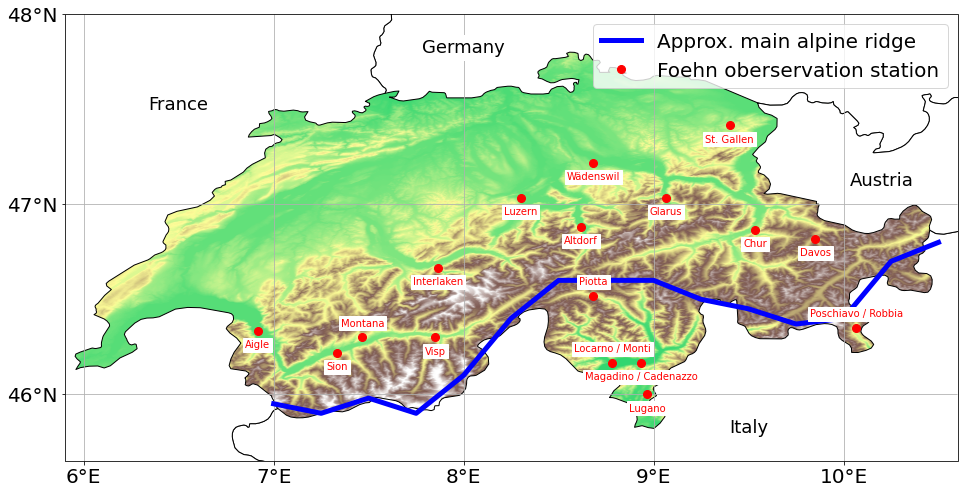

In [24]:
# Define projection and extent of plot
extent = [5.9, 10.6, 45.65, 48]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# Define looks of colormap
terrain = cm.get_cmap('terrain', 512)
newcmp = ListedColormap(terrain(np.linspace(0.3, 1.2, 256)))

# Plot topography
plt.scatter(df["lon"], df["lat"], c=df["z"], s=5, cmap=newcmp)

# Get country borders and plot them
shpfilename = shapereader.natural_earth(resolution="10m", category='cultural', name='admin_0_countries')
df_countries = geopandas.read_file(shpfilename)
for country in ["Germany", "Italy", "France", "Austria"]:
    if country == "Austria":
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values
    else:
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values[0]
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='black', zorder=1)
    
# Add country labels
kwargs = {"textcoords": "offset points", "xytext": (0,0), "ha": "center", "color": "black", "backgroundcolor": "w", "fontsize": 18 }
plt.annotate("Italy", (9.5, 45.8), **kwargs)
plt.annotate("France", (6.5, 47.5), **kwargs)
plt.annotate("Germany", (8, 47.8), **kwargs)
plt.annotate("Austria", (10.2, 47.1), **kwargs)

# Make gridlines and axis labels    
ax.gridlines(xlocs=range(6,11), ylocs=range(46,48))
ax.set_xticks(range(6,11))
ax.set_xticklabels([f"{i}°E" for i in range(6,11)])
ax.set_yticks(range(46,49))
ax.set_yticklabels([f"{i}°N" for i in range(46,49)])

# Define and plot main alpine ridge
main_alpine_crest = np.array([[7, 45.95],
                              [7.25, 45.9],
                              [7.5, 45.98],
                              [7.75, 45.9],
                              [8, 46.1],
                              [8.25, 46.4],
                              [8.5,46.6],
                              [8.75,46.6],
                              [9, 46.6],
                              [9.25, 46.5],
                              [9.5, 46.45],
                              [9.75, 46.37],
                              [10,46.4],
                              [10.25,46.7],
                              [10.5, 46.8]])
plt.plot(main_alpine_crest[:,0], main_alpine_crest[:,1], "b-",  linewidth=5)

# Plot foehn stations
plt.plot(df_stations["longitude"], df_stations["latitude"], "ro", markersize=8)

# Plot foehn station labels and move to non-overlapping position
for i, row in df_stations.iterrows():
    kwargs = {"text": row["name"], "xy": (row["longitude"], row["latitude"]), "textcoords": "offset points", "ha": "center", "color": "r", "backgroundcolor": "w", "fontsize": 10 }
    if row["abbreviation"] in ["MVE", "PIO", "SBE", "ROB", "AND", "OTL", "VAD"]: # Place label north
        plt.annotate(**kwargs, xytext=(0,11))
    elif row["abbreviation"] in ["CEV"]: # Place label west
        kwargs.update({"ha":"right"})
        plt.annotate(**kwargs, xytext=(-8,-3))
    else: # Place label south
        plt.annotate(**kwargs, xytext=(0,-17))
        
# Format legend
blue_cross = Line2D([], [], color='blue', linestyle='-', linewidth=5, label='Approx. main alpine ridge')
red_oval = Line2D([], [], markeredgecolor='red',color ="red", marker='o', linestyle='None', markersize=8, label="Foehn oberservation station")
plt.legend(handles=[blue_cross, red_oval], loc=1)

# Plot fire and foehn stations

/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '')

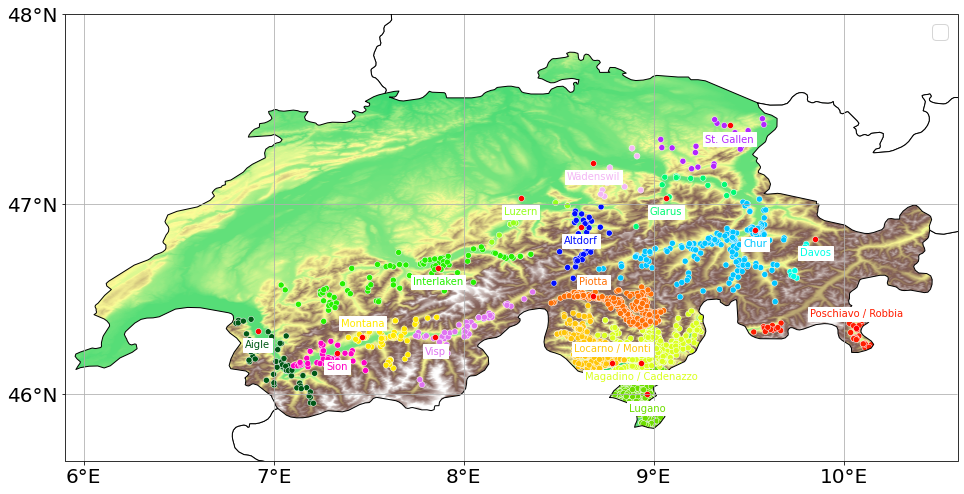

In [25]:
extent = [5.9, 10.6, 45.65, 48]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# Plot topography
plt.scatter(df["lon"], df["lat"], c=df["z"], s=5, cmap=newcmp)

# Get country borders and plot them
shpfilename = shapereader.natural_earth(resolution="10m", category='cultural', name='admin_0_countries')
df_countries = geopandas.read_file(shpfilename)
for country in ["Germany", "Italy", "France", "Austria"]:
    if country == "Austria":
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values
    else:
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values[0]
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='black', zorder=1)

# Plot fires
unique = df_fires["abbreviation"].unique()
palette = dict(zip(unique, sns.color_palette(palette="gist_ncar", n_colors=len(unique))))
sns.scatterplot(x="longitude", y="latitude", data=df_fires, hue="abbreviation", palette=palette)

# Plot foehn stations
sns.scatterplot(df_stations["longitude"], df_stations["latitude"], color="r")

# Format legend
# blue_cross = Line2D([], [], color='blue', marker='x', linestyle='None',
#                           markersize=10, label='Forest fire')
# red_oval = Line2D([], [], markeredgecolor='red',color ="red", marker='o', linestyle='None',
#                           markersize=8, label="Foehn oberservation station")
# plt.legend(handles=[blue_cross, red_oval], loc=2)
plt.legend("")

# Plot foehn station labels and move to non-overlapping position
for i, row in df_stations.iterrows():
    kwargs = {"text": row["name"], "xy": (row["longitude"], row["latitude"]), "textcoords": "offset points", "ha": "center", "color": palette[row["abbreviation"]], "backgroundcolor": "w", "fontsize": 10 }
    if row["abbreviation"] in ["MVE", "PIO", "SBE", "ROB", "AND", "OTL", "VAD"]: # Place label north
        plt.annotate(**kwargs, xytext=(0,11))
    elif row["abbreviation"] in ["CEV"]: # Place label west
        kwargs.update({"ha":"right"})
        plt.annotate(**kwargs, xytext=(-8,-3))
    else: # Place label south
        plt.annotate(**kwargs, xytext=(0,-17))
    
# Make gridlines and axis labels    
ax.gridlines(xlocs=range(6,11), ylocs=range(46,48))
ax.set_xticks(range(6,11))
ax.set_xticklabels([f"{i}°E" for i in range(6,11)])
ax.set_yticks(range(46,49))
ax.set_yticklabels([f"{i}°N" for i in range(46,49)])
plt.xlabel("")
plt.ylabel("")

# Save figure
# fig_name = f'/data/08_reporting/ForestFiresFoehnStation.pdf'
# plt.savefig(fig_name, bbox_inches='tight', dpi=200)
# print(f"Saved figure at: {fig_name}")

Text(0, 0.5, '')

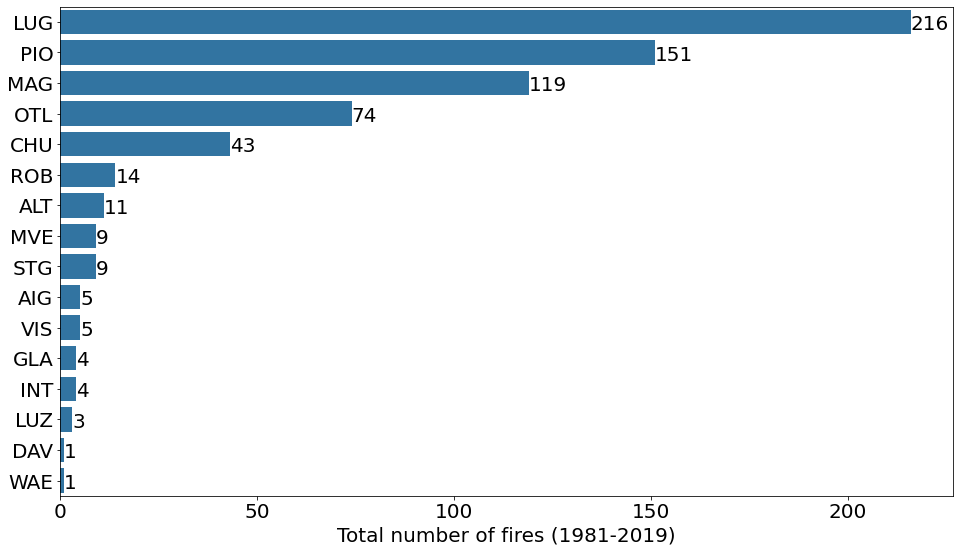

In [26]:
df_temp = df_fires.loc[df_fires["foehn_minutes_during_6_hours_after_start_of_fire"]>0, :].groupby("abbreviation", as_index=False).count().sort_values("total [ha]", ascending=False).reset_index()
df_temp
ax = sns.barplot(x=df_temp["total [ha]"], y=df_temp["abbreviation"], color="tab:blue")
for index, row in df_temp.iterrows():
    ax.text(row["total [ha]"], index+0.25, row["total [ha]"], color='black', ha="left")
plt.xlabel("Total number of fires (1981-2019)")
plt.ylabel("")

# Plot ellipsoids around each stations

In [ ]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
import matplotlib.lines as mlines

def geodesic_point_expansion(lat, lon, km):
    """
    Expand a point to a circle
    @param lat, lon: Coordinates
    @param km: Size of circle in km
    @returns: List of tuples with coords
    """
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        pyproj.Proj('+proj=longlat +datum=WGS84'))
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

In [ ]:
domain = [5.9, 10.6, 45.65, 48]
m = Mapfigure(domain=domain)
fig = plt.figure()

# Plot fires
plt.scatter(df_fires["longitude"], df_fires["latitude"], marker="x")

# Plot ellipsoids for each station
for i in range(len(df_stations["longitude"])):
    ellipse = geodesic_point_expansion(df_stations.loc[i, "latitude"], df_stations.loc[i, "longitude"], 20)
    x= [point[0] for point in ellipse]
    y= [point[1] for point in ellipse]
    plt.plot(x, y, "-", color="r", linewidth=1)

# Format legend
blue_cross = mlines.Line2D([], [], color='blue', marker='x', linestyle='None',
                          markersize=10, label='Forest fire')
red_oval = mlines.Line2D([], [], markeredgecolor='red',color ="white", marker='o', linestyle='None',
                          markersize=15, label="Foehn oberservation station radius")
plt.legend(handles=[blue_cross, red_oval], loc=2)
    
m.drawmap(nbrem=1, nbrep=1)
plt.gca().set_aspect("equal")

# Save figure
fig_name = f'/data/08_reporting/ForestFiresFoehnStationRadius.pdf'
plt.savefig(fig_name, bbox_inches='tight', dpi=200)
print(f"Saved figure at: {fig_name}")